In [24]:
import pandas as pd

df = pd.read_csv("run/accuracy/datasets/movies_sampled_labelled.csv")

# loop through each row, canonicalize values to YES/NO 
# for index, row in df.iterrows():
#     df.at[index, "Mistral-7B-Instruct"] = row["Mistral-7B-Instruct"].strip().upper()
#     df.at[index, "gemma-2-2b-it"] = row["gemma-2-2b-it"].strip().upper()
#     df.at[index, "llama2-13b-chat-hf"] = row["llama2-13b-chat-hf"].strip().upper()
#     df.at[index, "llama2-7b-chat-hf"] = row["llama2-7b-chat-hf"].strip().upper()
# df.to_csv("run/accuracy/datasets/movies_sampled_labelled.csv", index=False)

In [25]:
mapping = {"YES": 1, "NO": 0}
def map_labels(column):
    return [mapping[item] for item in df[column].tolist()]


In [26]:
# gpt4o = map_labels("gpt4o")
llama3_8b = map_labels("llama3-8b")
llama3_70b = map_labels("llama3-70b")
mistral_7b = map_labels( "Mistral-7B-Instruct")
gemma_2b = map_labels("gemma-2-2b-it")
llama2_13b = map_labels("llama2-13b-chat-hf")
llama2_7b = map_labels("llama2-7b-chat-hf")
manual = map_labels("manual_labels")
NUM_TRIALS = 20
ALPHA = 0.2
models: list[list[int]] = [llama3_8b, llama3_70b, mistral_7b, gemma_2b, llama2_13b, llama2_7b]

In [27]:
"""
Multiplicative weight update
"""
import math

def mwu(models: list[list[int]], GT: list[int]) -> None:
    weights = [1.] * len(models)
    accs = [0.] * len(models)
    unique_labels = list(set(GT))
    print(unique_labels)

    for j, m in enumerate(models):
        correct = sum([1 for i in range(len(m)) if m[i] == GT[i]])
        accs[j] = correct / len(m)

    true_best_model_index = accs.index(max(accs))
    print(f"True best model index: {true_best_model_index}")
    print(f"Accuracies: {accs}")

    for _ in range(NUM_TRIALS):
        # expected_h_x = [0] * len(GT)
        max_info: float = 0
        best_index: int = -1
        for i, hs in enumerate(zip(*models)):
            # expected_h_x[i] = sum([w * hs[j] for j, w in enumerate(weights)]) / sum(weights)
            # info = min(expected_h_x[i], 1 - expected_h_x[i])
            majority = 0.
            for l in unique_labels:
                curr = 0.
                for j, w in enumerate(weights):
                    if hs[j] == l:
                        curr += w
                majority = max(majority, curr)
            info = 1 - majority * 1.0 / sum(weights)
            if info > max_info:
                max_info = info
                best_index = i
        gt = GT[best_index]
        print(f"Selected index: {best_index} with info {max_info} and GT {gt}")
        for j, m in enumerate(models):
            if m[best_index] != gt:
                weights[j] *= math.exp(-ALPHA)
        del GT[best_index]
        for model in models:
            del model[best_index]
    best_model_index = weights.index(max(weights))
    print(f"Best model index by MWU: {best_model_index}")
    print(f"Weights: {weights}")

In [28]:
# plot the weights evolution over trials for each model
def mwu_with_tracking(models: list[list[int]], GT: list[int]) -> None:
    weights = [1.] * len(models)
    accs = [0.] * len(models)
    unique_labels = list(set(GT))
    print(unique_labels)

    for j, m in enumerate(models):
        correct = sum([1 for i in range(len(m)) if m[i] == GT[i]])
        accs[j] = correct / len(m)

    true_best_model_index = accs.index(max(accs))
    print(f"True best model index: {true_best_model_index}")
    print(f"Accuracies: {accs}")

    weight_evolution = [weights.copy()]

    for _ in range(NUM_TRIALS):
        max_info: float = 0
        best_index: int = -1
        for i, hs in enumerate(zip(*models)):
            majority = 0.
            for l in unique_labels:
                curr = 0.
                for j, w in enumerate(weights):
                    if hs[j] == l:
                        curr += w
                majority = max(majority, curr)
            info = 1 - majority * 1.0 / sum(weights)
            if info > max_info:
                max_info = info
                best_index = i
        gt = GT[best_index]
        print(f"Selected index: {best_index} with info {max_info} and GT {gt}")
        for j, m in enumerate(models):
            if m[best_index] != gt:
                weights[j] *= math.exp(-ALPHA)
        weight_evolution.append(weights.copy())
        del GT[best_index]
        for model in models:
            del model[best_index]
    best_model_index = weights.index(max(weights))
    print(f"Best model index by MWU: {best_model_index}")
    print(f"Weights: {weights}")
    return weight_evolution, accs

def plot_weight_and_accuracy(weight_evolution: list[list[float]], accuracies: list[float]) -> None:
    import matplotlib.pyplot as plt

    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for i, weights in enumerate(per_model_weights):
        acc = accuracies[i]
        plt.plot(weights, label=f"Model {i} (acc={acc:.3f})")

    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()



[0, 1]
True best model index: 2
Accuracies: [0.94, 0.86, 0.96, 0.89, 0.86, 0.3]
Selected index: 1 with info 0.5 and GT 1
Selected index: 39 with info 0.4833886675625073 and GT 1
Selected index: 48 with info 0.4337739603221912 and GT 0
Selected index: 62 with info 0.4833886675625073 and GT 0
Selected index: 14 with info 0.3677737841435248 and GT 1
Selected index: 2 with info 0.35476960646490474 and GT 0
Selected index: 10 with info 0.3447881132734971 and GT 0
Selected index: 21 with info 0.3522618280931834 and GT 1
Selected index: 7 with info 0.3080797916072313 and GT 0
Selected index: 10 with info 0.2967279863601795 and GT 0
Selected index: 59 with info 0.3135955571346577 and GT 1
Selected index: 21 with info 0.27222502069878274 and GT 0
Selected index: 43 with info 0.23444807674115165 and GT 1
Selected index: 46 with info 0.2722250206987826 and GT 0
Selected index: 53 with info 0.23444807674115153 and GT 0
Selected index: 26 with info 0.2248735469714781 and GT 0
Selected index: 52 wit

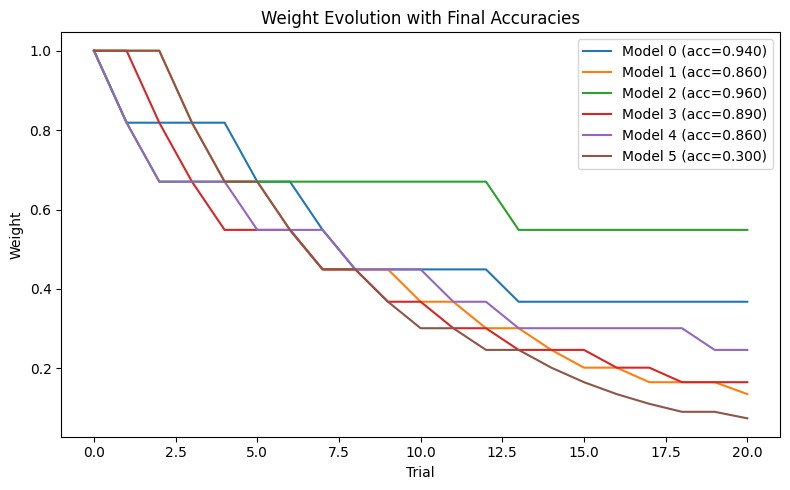

In [29]:
# mwu(models, manual)
weight_evolution, accs = mwu_with_tracking(models, manual)
plot_weight_and_accuracy(weight_evolution, accs)